In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *
from tqdm import tqdm 
from ultralytics import RTDETR
from multiprocessing import Pool
from tracking import *

In [3]:
fundamental_matrices = {
    "A" : {
        "B": np.load("fundamental_matrices/AB.npy"),
        "C": np.load("fundamental_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("fundamental_matrices/BA.npy"),
        "C": np.load("fundamental_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("fundamental_matrices/CB.npy"),
        "A": np.load("fundamental_matrices/CA.npy"),
    }
}

In [4]:
homography_matrices = {
    "A" : {
        "B": np.load("homography_matrices/AB.npy"),
        "C": np.load("homography_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("homography_matrices/BA.npy"),
        "C": np.load("homography_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("homography_matrices/CB.npy"),
        "A": np.load("homography_matrices/CA.npy"),
    }
}

In [5]:
video = "11"

In [6]:
if 'query' in globals():
    del query
if 'reference' in globals():
    del reference

a = load_video(f"train/task2/{video}_1.mp4")
b = load_video(f"train/task2/{video}_2.mp4")
print(a.num_frames())
print(b.num_frames())

776
826


In [7]:
camera_a = a.get_camera()
camera_b = b.get_camera()

print("A camera:", camera_a)
print("B camera:", camera_b)

A camera: C
B camera: A


In [8]:
F = fundamental_matrices[camera_a][camera_b] 
print(F)
F_inv = fundamental_matrices[camera_b][camera_a] 
print(F_inv)

[[-5.7527e-07 -9.7317e-06    0.003172]
 [ 5.5402e-06  7.1693e-06   0.0029729]
 [ -0.0003995  -0.0036525           1]]
[[-5.7527e-07  5.5402e-06  -0.0003995]
 [-9.7317e-06  7.1693e-06  -0.0036525]
 [   0.003172   0.0029729           1]]


In [9]:
H = homography_matrices[camera_a][camera_b]
print(H)
H_inv = homography_matrices[camera_b][camera_a]
print(H_inv)

[[    0.82196     -1.7032      4155.6]
 [   -0.14479      2.8583     -238.45]
 [-0.00067971   0.0035915           1]]
[[     -4.734     -25.259       17296]
 [   -0.76251     -7.9624      3239.4]
 [ -0.0020016  -0.0028567           1]]


In [10]:
def read_box(path):
    with open(path, "r") as f:
        lines = f.readlines()
    _, box = lines

    box = box.strip()
    _index, x1, y1, x2, y2 = list(map(int , box.split(" ")))
    return (x1, y1, x2, y2)

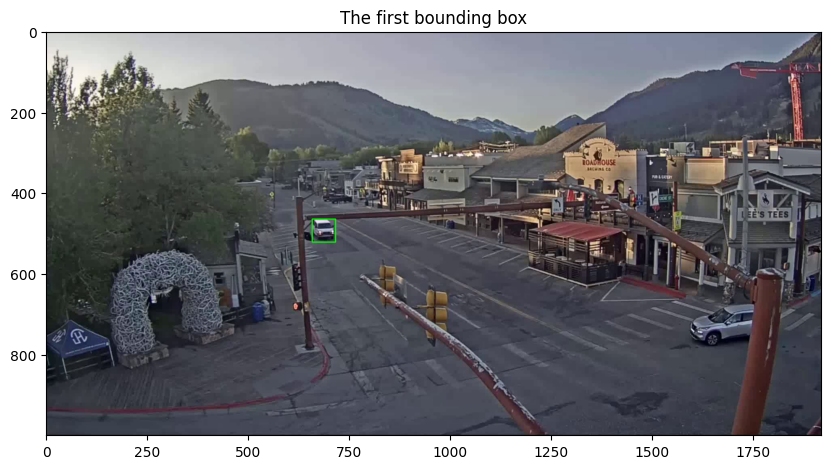

In [11]:
initial_bbox = read_box(f"train/task2/{video}_1.txt")
plot = a.get_frame(0).raw().copy()
cv.rectangle(plot, initial_bbox[:2], initial_bbox[2:], (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.title("The first bounding box")
plt.imshow(plot)

In [12]:
a.do_tracking(visualize=False)
b.do_tracking(visualize=False)

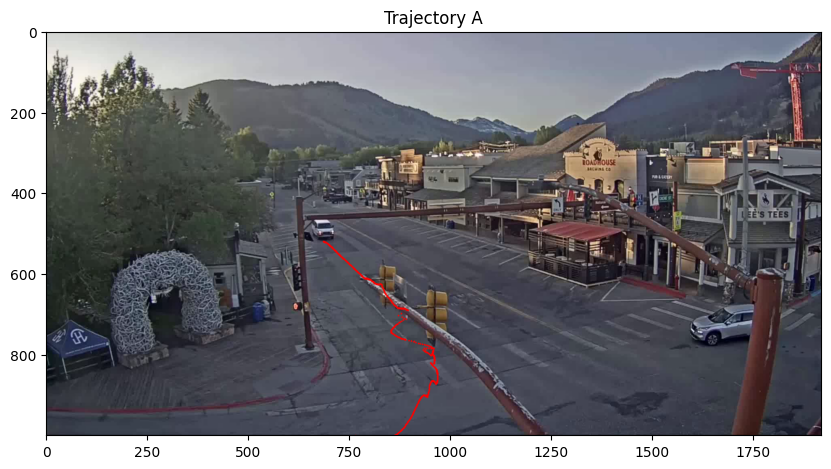

In [13]:
trajectory_a = compute_trajectory(a, initial_bbox, visualize=False)
plot = a.get_frame(0).raw().copy()
for point in trajectory_a.trajectory():
    cv.circle(plot, point, 2, (255, 0, 0), -1)
plt.figure(figsize=(10, 10))
plt.title("Trajectory A")
plt.imshow(plot)

2265920


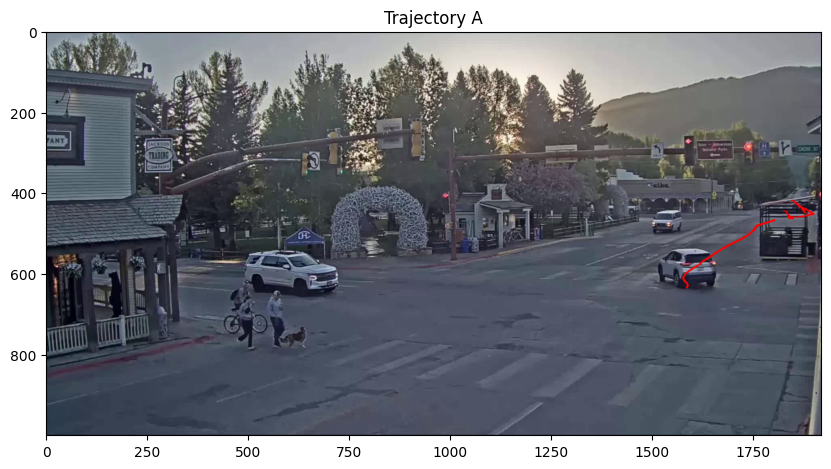

2265920


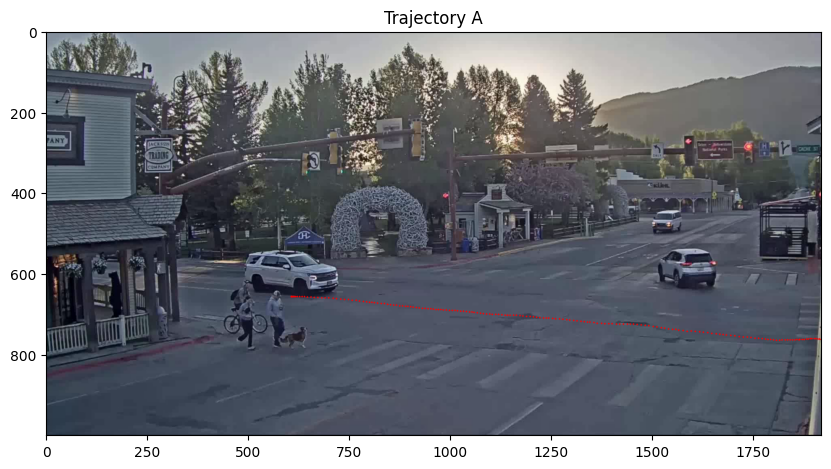

172803.21092784818


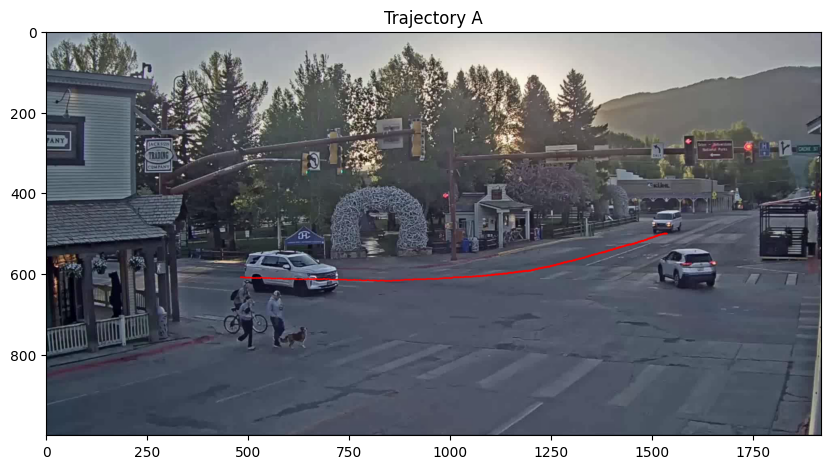

2265920


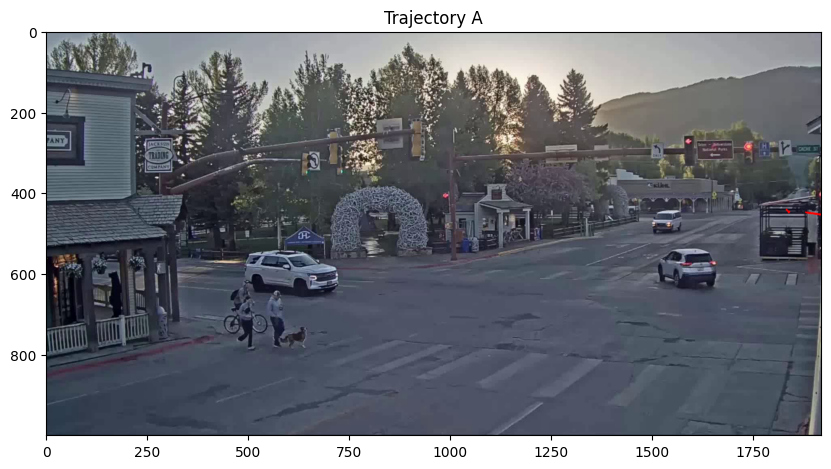

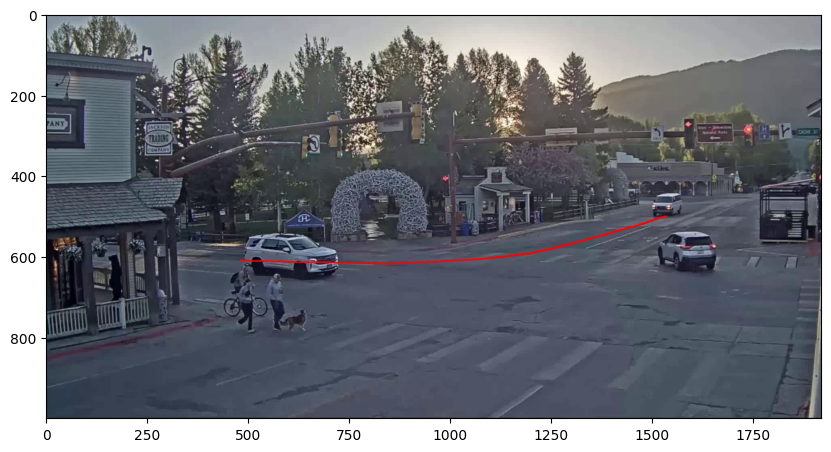

In [14]:
from time import time 

objects = b.get_frame(0).objects()

best_trajectory = None
min_cost = np.inf

for object in objects:
    trajectory_b = compute_trajectory(b, object["bbox"], visualize=False)

    cost = compare_trajectory(trajectory_a.trajectory(), trajectory_b.trajectory(), H, H_inv)
    if cost < min_cost:
        min_cost = cost
        best_trajectory = trajectory_b

    print(cost)
    plot = b.get_frame(0).raw().copy()
    for point in trajectory_b.trajectory():
        cv.circle(plot, point, 2, (255, 0, 0), -1)
    plt.figure(figsize=(10, 10))
    plt.title("Trajectory A")
    plt.imshow(plot)
    plt.show()
    
plot = b.get_frame(0).raw().copy()
for point in best_trajectory.trajectory():
    cv.circle(plot, point, 2, (255, 0, 0), -1)
plt.figure(figsize=(10, 10))
plt.imshow(plot)

In [15]:
for i in range(a.num_frames()):
    copy = a.get_frame(i).raw().copy()
    bbox = trajectory_a.bounding_boxes()[i]
    cv.rectangle(copy, bbox[:2], bbox[2:], (0, 255, 0), 2)
    cv.imshow("A", copy)
    cv.waitKey(10)
cv.destroyAllWindows()

In [16]:
for i in range(b.num_frames()):
    copy = b.get_frame(i).raw().copy()
    bbox = best_trajectory.bounding_boxes()[i]
    cv.rectangle(copy, bbox[:2], bbox[2:], (0, 255, 0), 2)
    cv.imshow("B", copy)
    cv.waitKey(10)
cv.destroyAllWindows()